In [1675]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1676]:
import numpy as np
import matplotlib.pyplot as plt


from neuron_population import NeuronPopulation
from connectome import Connectome
from overhead import Simulation

In [1677]:
dt = 0.1

In [1678]:
# Neuron population parameters
layer_distribution = [2, 10, 2]
n_layers = 3
neuron_types = ["TRN", "p23", "nb"]
n_neuron_types = len(neuron_types)
inhibitory = [False, False, True]
dist_layer1 = np.array([1, 0, 0])
dist_layer2 = np.array([0, 8, 0])
dist_layer3 = np.array([1, 0, 0])
neuron_distribution = [dist_layer1, dist_layer2, dist_layer3]
threshold_decay = np.exp(-dt / 5)
layer_distances = np.zeros((n_layers, n_layers))
# mm
layer_distances[0, 0] = 0.6
layer_distances[1, 1] = 0.6
layer_distances[2, 2] = 0.6
layer_distances[0, 1] = 5.0
layer_distances[1, 0] = 5.0
layer_distances[1, 2] = 5.0
layer_distances[2, 1] = 5.0
layer_distances[0, 2] = 10.0
layer_distances[2, 0] = 10.0

In [1679]:
neuron_pop = NeuronPopulation(
    layer_distribution,
    neuron_distribution,
    layer_distances,
    neuron_types,
    inhibitory,
    threshold_decay,
    threshold_mult=1.15
)

In [1680]:
# Connectome
max_synapses = 10
synapse_strength = np.ones((n_layers, n_layers))
# neuron_types = ["p23", "TRN", "b", "nb"]
connectivity_probability = np.ones((n_layers, n_layers, n_neuron_types, n_neuron_types+2))


connectivity_probability[:,:,:,-2] = 0.0  # Self connections
connectivity_probability[:,:,:,-1] = 0.0  # No empty connections
# No inter-connections for input and output layers
connectivity_probability[0, 0, :, :-2] = 0
connectivity_probability[2, 2, :, :-2] = 0
# Only flow in one direction
connectivity_probability[1, 0, :, :-2] = 0.0
connectivity_probability[2, 1, :, :-2] = 0.0
connectivity_probability[2, 0, :, :-2] = 0.0
# No jump from input to output
connectivity_probability[0, 2, :, :-2] = 0.0

In [1681]:
connectome = Connectome(
    max_synapses,
    neuron_pop,
    connectivity_probability,
    synapse_strength,
)

In [1682]:
connectome.M

array([[ 7,  8,  9, 11,  4,  7, 10,  4,  4,  2],
       [ 2,  3,  7,  6,  6,  5, 11,  4,  7,  8],
       [10, 13,  7,  6, 12,  7,  5,  6, 11,  4],
       [ 5,  7,  5,  8,  5,  4,  7,  7,  8,  8],
       [11, 11, 13,  3,  8,  3, 10, 10,  7, 10],
       [12,  9, 13,  6,  7, 13,  8,  7, 11,  3],
       [10,  7,  9,  9, 11,  2,  2,  5,  4,  8],
       [ 6,  4,  3, 10, 13, 13,  8,  5, 11,  2],
       [ 4,  3,  7, 13, 12,  2, 10, 10, 12,  3],
       [10,  7, 13,  7,  5,  5,  6, 13,  8, 13],
       [ 4,  8,  4,  6, 13, 13,  3, 11,  9,  8],
       [ 7, 13,  3,  3,  6,  9,  4,  7,  4,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [1683]:
# connectome.distances

In [1684]:
sim = Simulation(connectome, dt, stepper_type="adapt")
sim.plasticity.mirror_neurons = [(0, -2), (1, -1)]

In [1685]:
weights_t0 = connectome.W.copy()

In [1686]:
# connectome.W.copy()

In [1687]:
I_ext = np.zeros((neuron_pop.n_neurons))
I_ext[1] = 100
I_ext[2:-2] = 100

# I_ext = 100

for i in range(50000):
    sim.step(I_ext=I_ext)
    # print(sim.synapse_dynamics.g_ST)
    # if np.sum(sim.pre_spikes) > 0:
        # print(f"Step {i}, {sim.t_now}, heap size: {(sim.axonal_dynamics._heap)}")
        # print(sim.pre_spikes)

weights_t1 = connectome.W.copy()

In [1688]:
sim.plasticity.activity_trace

array([0.04042094, 1.36994818, 0.40515541, 0.3778169 , 0.37533944,
       0.37515063, 0.40489469, 0.37713293, 0.37992721, 0.37029967,
       0.37266775, 0.37118378, 0.04042094, 1.36994818])

In [1689]:
# sim.synapse_dynamics.g_GABA_B

In [1690]:
neuron_pop.inhibitory_mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [1691]:
sim.neuron_states.V

array([-63.82925096, -53.30340472, -44.69579979, -55.39821437,
       -55.84355843, -54.80185813, -66.06961031, -56.19461357,
       -57.17325931, -52.36198152, -55.10481701, -56.27411168,
       -61.44956224, -59.20634358])

In [1692]:
weights_t1 # [neuron_pop.inhibitory_mask]

array([[0.08132041, 0.00097153, 0.30884171, 0.08460676, 0.07926633,
        0.04394072, 0.25410548, 0.13048259, 0.17638564, 0.0639896 ],
       [0.10171827, 0.06846979, 0.03626807, 0.08744324, 0.09902085,
        0.05797134, 0.08034975, 0.05133088, 0.05891654, 0.01037449],
       [0.00475538, 0.04748111, 0.09737194, 0.03150333, 0.1551703 ,
        0.08575944, 0.08876705, 0.06052419, 0.04665593, 0.10523993],
       [0.16329527, 0.04636691, 0.16774687, 0.05352183, 0.09424798,
        0.08749377, 0.03779758, 0.0886519 , 0.08394291, 0.10059685],
       [0.16742703, 0.16262411, 0.09963944, 0.10838956, 0.15863812,
        0.11488922, 0.17354862, 0.0770741 , 0.07070709, 0.18983295],
       [0.16130537, 0.27781755, 0.34501228, 0.14340751, 0.06803902,
        0.31769788, 0.12257779, 0.00981808, 0.11455006, 0.08798337],
       [0.07103538, 0.0744853 , 0.14169557, 0.12709132, 0.14776912,
        0.27815271, 0.16883366, 0.14280173, 0.12517371, 0.10070121],
       [0.10904066, 0.05817012, 0.0447660

In [1693]:
weights_t1 -   weights_t0

array([[-1.03843856, -0.00741546, -0.98028779, -0.46209362, -0.70388873,
        -0.5611106 , -1.26792984, -1.15869162, -1.56631285, -0.2526786 ],
       [-0.73449069, -1.12025717, -0.90054994, -1.23601885, -1.39966956,
        -0.73179937, -0.83002843, -0.70816346, -1.46292023, -0.13327531],
       [-0.03078351, -0.16268735, -1.80815914, -0.3049573 , -1.26913234,
        -1.59251952, -0.85289249, -0.58588391, -0.36560406, -1.25443419],
       [-1.68105376, -0.92646999, -1.72688107, -0.60332974, -0.97024199,
        -1.12228846, -0.75524385, -1.77137819, -0.94625429, -1.13398731],
       [-1.34000419, -1.30156398, -0.3697549 , -1.37923871, -1.70841974,
        -1.46194568, -1.15536394, -0.51310485, -1.34421583, -1.26377355],
       [-1.33438938, -1.1647994 , -1.28529593, -1.42086433, -1.30046192,
        -1.18353989, -1.3266606 , -0.18765752, -0.92135378, -1.12534214],
       [-0.46201578, -1.3905795 , -0.57842606, -0.51880899, -1.16343085,
        -1.55651091, -0.94477396, -1.37877615

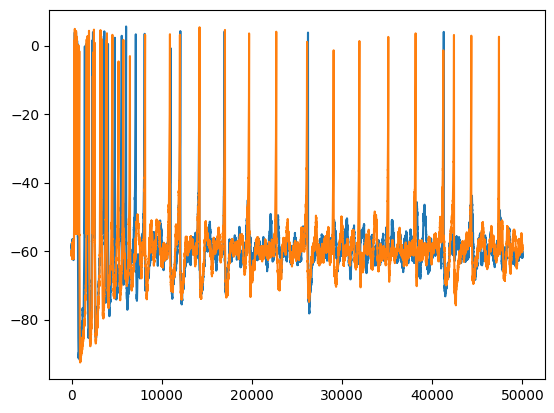

In [1694]:
plt.plot(np.array(sim.stats.Vs)[:, neuron_pop.get_neurons_from_layer(2)])
plt.show()

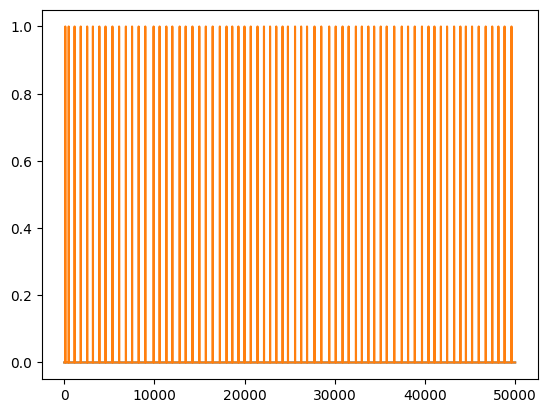

In [1695]:
plt.plot(np.array(sim.stats.spikes)[:, neuron_pop.get_neurons_from_layer(0)])
plt.show()